# Local attachement demonstrator
This notebook implements and demonstrates the `LocalAttachement_v2` algorithm from the referene version of `FinalModel.py` in a tensorized form.

### First load an configure data
we will load the toymodel and create a symmetrized weighted adjacency matrix

In [1]:
import os

In [2]:
os.environ["DGLBACKEND"] = "pytorch"

In [3]:
import torch 
import pandas as pd
import dgl
from dgl.data import DGLDataset
import dgl.function as fn
import numpy as np

### utility functions

In [4]:
from dgl.sparse import spmatrix

def adj_mat_with_edge_prop(m, etype= None, eprop=None):
    
    
    etype = m.to_canonical_etype(etype)
    indices = torch.stack(m.all_edges(etype=etype))
    shape = (m.num_nodes(etype[0]), m.number_of_nodes(etype[2]))
    if eprop is not None:
        val = m.edges[etype].data[eprop].flatten()
    else:
        val = None
        
    return spmatrix(
        indices,
        val=val,
        shape=shape,
    )

In [5]:
import matplotlib.pyplot as plt

import networkx as nx
def plot_net(net,options = None):
    netG = dgl.to_networkx(net)
    plt.figure(figsize=[15,7])
    if options != None:
        nx.draw(netG,**options)
    else:
        nx.draw(netG)

In [6]:
def triu(spm):
    mask = spm.row <= spm.col
    return dgl.sparse.from_coo(spm.row[mask],spm.col[mask],spm.val[mask],shape=spm.shape)

In [7]:
def sym_from_triu(triuspm):
    return triuspm + triuspm.T

In [8]:
def sparse_from_mask(om, mask):
    return dgl.sparse.from_coo(om.row[mask],om.col[mask],om.val[mask],shape=om.shape)

### load data

In [9]:
ds = dgl.data.CSVDataset('./toy_dataset/toy_local_attach')

Done loading data from cached files.


In [10]:
g = ds[0]

In [11]:
g.edata['w'] = torch.rand(g.num_edges(),1)

### Visualize graph

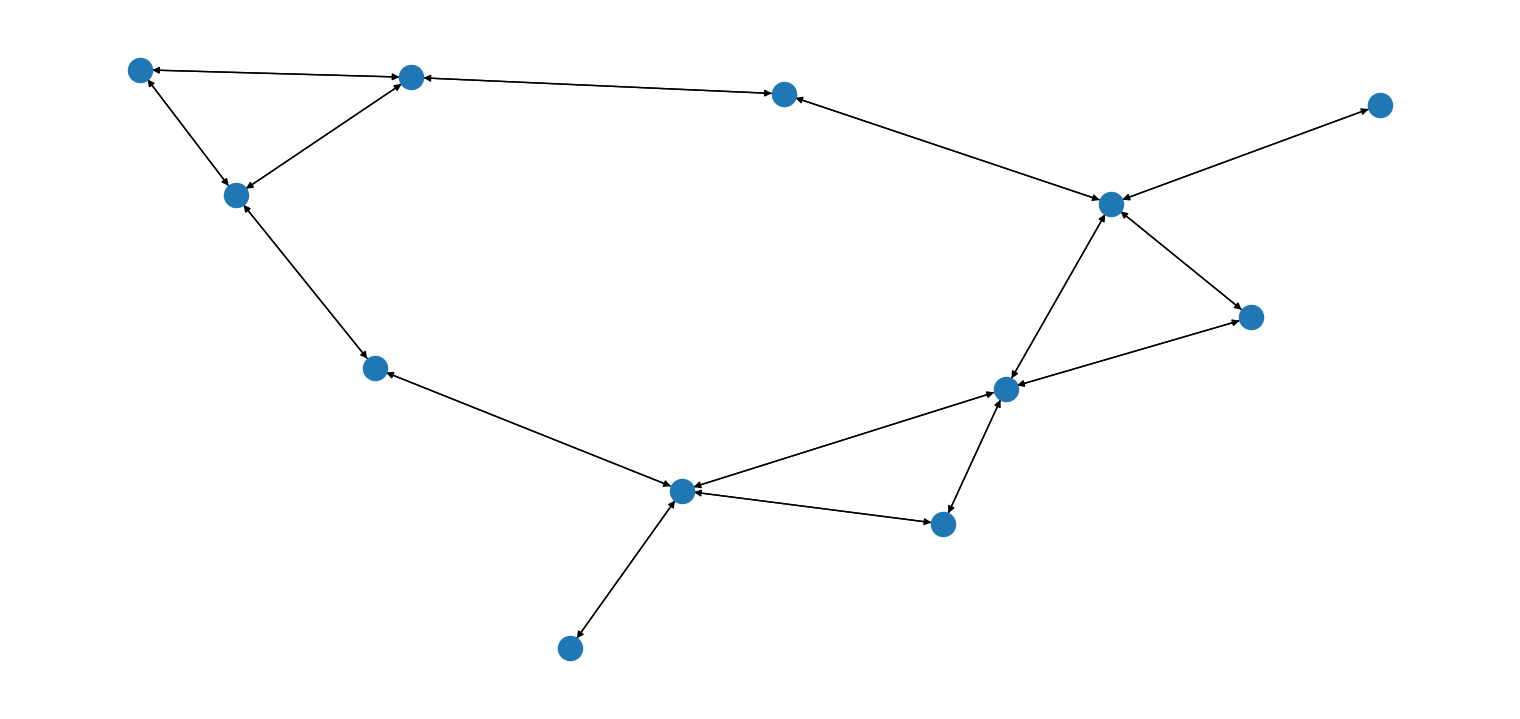

In [12]:
plot_net(g)

### Get adjacency matrix with edge data (weigths)
in the case of the toy model used here the weights must first be symmetrized. In a real application this matrix would already be symmetrical.

In [13]:
adje = adj_mat_with_edge_prop(g, eprop='w')

In [14]:
sadje = sym_from_triu(triu(adje))

#### This constitutes the symmetrical adjacency matrix with edge weights

In [15]:
sadje

SparseMatrix(indices=tensor([[ 0,  0,  1,  2,  2,  2,  2,  3,  3,  4,  4,  4,  4,  5,  5,  6,  6,  6,
                               6,  7,  7,  7,  8,  9,  9, 10, 10, 10, 11, 11],
                             [ 2,  6,  2,  0,  1,  3,  6,  2,  7,  5,  6,  8,  9,  4,  6,  0,  2,  4,
                               5,  3, 10, 11,  4,  4, 10,  7,  9, 11,  7, 10]]),
             values=tensor([0.4238, 0.6814, 0.9372, 0.4238, 0.9372, 0.1789, 0.1972, 0.1789, 0.6621,
                            0.3166, 0.0904, 0.3917, 0.2111, 0.3166, 0.0117, 0.6814, 0.1972, 0.0904,
                            0.0117, 0.6621, 0.6730, 0.6281, 0.3917, 0.2111, 0.9476, 0.6730, 0.9476,
                            0.3691, 0.6281, 0.3691]),
             shape=(12, 12), nnz=30)

### Select node pairs (src, dst) as elements of the matrix 

An element (i,j) of the adjacency matrix represents an edje between the nodes i (src) and j (dst). A selection based on the weights of their connections can therefore be realized by drawing using a random seletion field applied to the adjacency matrix.

NOTE: ALthough the weights of the adjacency matrix are symmetrical, because we assume a bi-directional edge between nodes, for this selection porocess the distinction between src and dst node is relevant, and we make use of the full matrix

#### generate random seletion field

In [16]:
selfield = torch.rand(sadje.val.size()[0])

In [17]:
selfield

tensor([0.1986, 0.7066, 0.7127, 0.0044, 0.6885, 0.1414, 0.2857, 0.2443, 0.8066,
        0.4452, 0.2147, 0.7047, 0.2268, 0.3121, 0.7513, 0.2806, 0.0589, 0.5248,
        0.1961, 0.0407, 0.8186, 0.4830, 0.0167, 0.9298, 0.5772, 0.1514, 0.1862,
        0.8830, 0.0865, 0.3034])

##### Apply random field as mask selecting edges on weight

In [18]:
selmask = sadje.val > selfield

In [19]:
selmask

tensor([ True, False,  True,  True,  True,  True, False, False, False, False,
        False, False, False,  True, False,  True,  True, False, False,  True,
        False,  True,  True, False,  True,  True,  True, False,  True,  True])

In [20]:
sadje.val[selmask]

tensor([0.4238, 0.9372, 0.4238, 0.9372, 0.1789, 0.3166, 0.6814, 0.1972, 0.6621,
        0.6281, 0.3917, 0.9476, 0.6730, 0.9476, 0.6281, 0.3691])

In [21]:
sadje.row[selmask]

tensor([ 0,  1,  2,  2,  2,  5,  6,  6,  7,  7,  8,  9, 10, 10, 11, 11])

In [22]:
sadje.col[selmask]

tensor([ 2,  2,  0,  1,  3,  4,  0,  2,  3, 11,  4, 10,  7,  9,  7, 10])

### Create a sparse matrix with ONLY the selected links

Note: This matrix does not need to be symmetrical, as the selection also reflects the definition of which nide is considerd the src node and which the dst node for the purpose of identifying neighbours

In [23]:
sadjesel = sparse_from_mask(sadje,selmask)

In [24]:
sadjesel.to_dense()

tensor([[0.0000, 0.0000, 0.4238, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9372, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.4238, 0.9372, 0.0000, 0.1789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3166, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.6814, 0.0000, 0.1972, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6621, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.6281],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3917, 0.0000, 0.0000, 0.0000, 0.0000,

## Neighbour selection

The following section implements the selection of non-mutual neighbours for the selected node pairs.

### identifying non-mutual neighbours

Consider the full adjcency matrix with all non-zero elements set to 1, and the matrix of selected edges, also with all non-zero elements set to one.
In both matrices, a given row i constitutes a list of all nodes j connected to i. Accordingly, if one adds a row i and a row j elementwise, the result constitutes a complete list of all neighbours of the node pair i,j. Mutual neigbours have a value of 2, non-mutual neighbours have. value of 1, and non-connected nodes retain a value of 0. To find only the neigbours of node j which are non-mutual to node i, we can then add row i again, resulting in a value of one only for those neigbours of j which are non-mutual to i.

### constructing a neighbour field matrix representation

Using this principle we can combine the adjacency matrix and the matrix of selected edges to construct a matrix representation of the neighbour field for all node pairs corresponding to selected edges. In esscence, we construct a matrix whose rows i correspond to the summed neigbour list of all elements i,j of the matrix of slected edges, following the schema described above. We additinally add entries for the identity in twofold to deal with the self-neigbouring and isolated nodes. This matrix represents the full neigbour field of the selected edges. Adding the matrix to the adjacency matrix we can identify potential new connections between node i and node k, where k is one of the non-mutual neighbours of the node paiir i,j defining the originally selected edge.

Note: if the same node i is selected in multiple edges (e.g. i,j1  and i,j2 with j1 != j2) this method will ALSO deselect all k which are mutual neigbours to j1 and j2. This is slightly more strict than the original sequential implementation where node k mutual to j1 and j2 would only be deselected if the connection i,k had been forged when connsidering the pair i,j1.

### possibility of selecting new links
Having identified the set of all potential new connections we can select them aat random weighted corresponding to the weight of the edge j,k. to this end, in addition to the integer value matrix indicating neighbours, we also constrcut the corresponding matrix with the values of the edge weights. As we are only interested in node pairs i,k where k is only connected to one neighbour of j, the edge weight j,k can be propagated in this manner.

In [25]:
def construct_neighbour_fields(selm,adjm):
    """
    This fucnction creates the row tensor, column tensor, link tensor, and value tensor
    needed to construct the neighbour field matrix/tensor in sparse representation. This is done by creating a list of the tensor
    representations for each element i,j of the matrix of selected edges by adding row i and row j of the adjacency
    matrix, and storing the result in row i. The list is subsequently concatenated to obtain a single tensor representation.
    In addition to the link tensor, which denotes the link status with and integer, the function also returns a value tensor with
    with entries corresponding to the weight of edge j,k.
    
    The rrsukting tensors can/will contain significant numbers of multiple assigments for an element i,k. This is addressed in
    subsequent processing.
    
    Input:
    
    :param: selm matrix of selected edges in sparse format (dgl.sparse.spmatrix)
    :param: adjm adjacency matrix witth edge weights as sparse values
    
    Output:
    
    :param: rowtensor (row tensor of the neighbour field matrix, compattible with sparse format)
    :param: coltensor (column tensor of the neighbour field matrix, compatible with sparse format)
    :param: ltensor (link tensor of the neighbouir field matrix, compatible with sparse format) 
    :param: valtensor (tensor with edge weights of link jk)
    
    """
    rtl = list()
    ctl = list()
    vtl = list()
    for i in range(selm.row.shape[0]):
        src = selm.row[i]
        dst = selm.col[i]
        srcten = torch.tensor([src])
        wsrcten = torch.tensor([0.])
        src_nids = adjm.col[adjm.row==src]
        wsrc_nids = adjm.val[adjm.row==src]
        dst_nids = adjm.col[adjm.row==dst]
        wdst_nids = adjm.val[adjm.row==dst]
        rv_src_nids = torch.ones_like(src_nids)*src
        rv_dst_nids = torch.ones_like(dst_nids)*src
        rv_nids = torch.cat((rv_src_nids,rv_dst_nids,srcten,srcten))
        cv_nids = torch.cat((src_nids,dst_nids,srcten,srcten))
        wv_nids = torch.cat((wsrc_nids,wdst_nids,wsrcten,wsrcten))
        rtl.append(rv_nids)
        ctl.append(cv_nids)
        vtl.append(wv_nids)
     
    rowtensor = torch.cat(rtl)
    coltensor = torch.cat(ctl)
    ltensor   = torch.ones_like(rowtensor)
    valtensor = torch.cat(vtl)
    
    return (rowtensor, coltensor, ltensor, valtensor)
    
        

Construct the neighbour field given the adjacency and selected edges matrix

In [26]:
nf = construct_neighbour_fields(sadjesel,sadje)

In [27]:
nf[0] # rowtensor

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
         9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [28]:
nf[1] # coltensor

tensor([ 2,  6,  0,  1,  3,  6,  0,  0,  2,  0,  1,  3,  6,  1,  1,  0,  1,  3,
         6,  2,  6,  2,  2,  0,  1,  3,  6,  2,  2,  2,  0,  1,  3,  6,  2,  7,
         2,  2,  4,  6,  5,  6,  8,  9,  5,  5,  0,  2,  4,  5,  2,  6,  6,  6,
         0,  2,  4,  5,  0,  1,  3,  6,  6,  6,  3, 10, 11,  2,  7,  7,  7,  3,
        10, 11,  7, 10,  7,  7,  4,  5,  6,  8,  9,  8,  8,  4, 10,  7,  9, 11,
         9,  9,  7,  9, 11,  3, 10, 11, 10, 10,  7,  9, 11,  4, 10, 10, 10,  7,
        10,  3, 10, 11, 11, 11,  7, 10,  7,  9, 11, 11, 11])

In [29]:
nf[2] # ltensor

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])

In [30]:
nf[3] #valtensor

tensor([0.4238, 0.6814, 0.4238, 0.9372, 0.1789, 0.1972, 0.0000, 0.0000, 0.9372,
        0.4238, 0.9372, 0.1789, 0.1972, 0.0000, 0.0000, 0.4238, 0.9372, 0.1789,
        0.1972, 0.4238, 0.6814, 0.0000, 0.0000, 0.4238, 0.9372, 0.1789, 0.1972,
        0.9372, 0.0000, 0.0000, 0.4238, 0.9372, 0.1789, 0.1972, 0.1789, 0.6621,
        0.0000, 0.0000, 0.3166, 0.0117, 0.3166, 0.0904, 0.3917, 0.2111, 0.0000,
        0.0000, 0.6814, 0.1972, 0.0904, 0.0117, 0.4238, 0.6814, 0.0000, 0.0000,
        0.6814, 0.1972, 0.0904, 0.0117, 0.4238, 0.9372, 0.1789, 0.1972, 0.0000,
        0.0000, 0.6621, 0.6730, 0.6281, 0.1789, 0.6621, 0.0000, 0.0000, 0.6621,
        0.6730, 0.6281, 0.6281, 0.3691, 0.0000, 0.0000, 0.3917, 0.3166, 0.0904,
        0.3917, 0.2111, 0.0000, 0.0000, 0.2111, 0.9476, 0.6730, 0.9476, 0.3691,
        0.0000, 0.0000, 0.6730, 0.9476, 0.3691, 0.6621, 0.6730, 0.6281, 0.0000,
        0.0000, 0.6730, 0.9476, 0.3691, 0.2111, 0.9476, 0.0000, 0.0000, 0.6281,
        0.3691, 0.6621, 0.6730, 0.6281, 

Construct sparse matriix representations of the neighbour fields based on the link tensor (for identifying potential new links) and the value tensor (for propagating the edge weights)

In [31]:
indices= torch.stack((nf[0],nf[1])) #stack indices into tensor for matrix construction
nfm = dgl.sparse.spmatrix(indices,nf[2],shape=sadjesel.shape) # create link neighbour fields
nfmv = dgl.sparse.spmatrix(indices,nf[3],shape=sadjesel.shape) # create value neighbour fields


In [32]:
nfm

SparseMatrix(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
                               2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
                               2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
                               6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
                               7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
                               9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
                              11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
                             [ 2,  6,  0,  1,  3,  6,  0,  0,  2,  0,  1,  3,  6,  1,  1,  0,  1,  3,
                               6,  2,  6,  2,  2,  0,  1,  3,  6,  2,  2,  2,  0,  1,  3,  6,  2,  7,
                               2,  2,  4,  6,  5,  6,  8,  9,  5,  5,  0,  2,  4,  5,  2,  6,  6,  6,

In [33]:
nfmv

SparseMatrix(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
                               2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
                               2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
                               6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
                               7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
                               9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
                              11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
                             [ 2,  6,  0,  1,  3,  6,  0,  0,  2,  0,  1,  3,  6,  1,  1,  0,  1,  3,
                               6,  2,  6,  2,  2,  0,  1,  3,  6,  2,  2,  2,  0,  1,  3,  6,  2,  7,
                               2,  2,  4,  6,  5,  6,  8,  9,  5,  5,  0,  2,  4,  5,  2,  6,  6,  6,

### dealing with multiple assgnments

As a result of their construction the tensors reppresenting the sparse neighbour field matrix can/will contain multiple assigments to the same eement. While this is not a problem for the matrix representation perse, these should be combined before matrix arithmetic opertations are be performed. This can be done using the `.coalesce()` method, which sums all assigments to a single matrix element.

In [34]:
nfmc =nfm.coalesce()
nfmvc = nfmv.coalesce()

In [35]:
nfmc.to_dense()

tensor([[3, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [1, 3, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [3, 3, 9, 3, 0, 0, 4, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 3, 2, 0, 1, 1, 0, 0],
        [3, 1, 3, 1, 2, 2, 6, 0, 0, 0, 0, 0],
        [0, 0, 1, 2, 0, 0, 0, 6, 0, 0, 3, 2],
        [0, 0, 0, 0, 1, 1, 1, 0, 3, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 0, 3, 1, 1],
        [0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 6, 3],
        [0, 0, 0, 1, 0, 0, 0, 3, 0, 1, 3, 6]])

In [36]:
nfmvc.to_dense()

tensor([[0.4238, 0.9372, 0.4238, 0.1789, 0.0000, 0.0000, 0.8785, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.4238, 0.9372, 0.9372, 0.1789, 0.0000, 0.0000, 0.1972, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [1.2713, 2.8116, 1.5399, 0.5368, 0.0000, 0.0000, 1.2729, 0.6621, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3166, 0.3166, 0.1021, 0.0000, 0.3917,
         0.2111, 0.0000, 0.0000],
        [1.7865, 0.9372, 0.8181, 0.1789, 0.1807, 0.0234, 0.8785, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1789, 1.3242, 0.0000, 0.0000, 0.0000, 1.2902, 0.0000,
         0.0000, 1.7151, 1.2562],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3917, 0.3166, 0.0904, 0.0000, 0.3917,

### Identify potential links
with the neighbourr fields at hand we create a matrix representattio of all potential links by adding the 1-values adjacency matrix and the link neighbour field matrix `nfmc` 

In [37]:
sadjeones = dgl.sparse.val_like(sadje,torch.ones(sadje.nnz,dtype=int))

In [38]:
sadjeones.to_dense()

tensor([[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

In [39]:
 possible_links = nfmc + sadjeones

In [40]:
possible_links.to_dense()

tensor([[3, 1, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0],
        [1, 3, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [4, 4, 9, 4, 0, 0, 5, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 2, 3, 3, 0, 1, 1, 0, 0],
        [4, 1, 4, 1, 3, 3, 6, 0, 0, 0, 0, 0],
        [0, 0, 1, 3, 0, 0, 0, 6, 0, 0, 4, 3],
        [0, 0, 0, 0, 2, 1, 1, 0, 3, 1, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 2, 1],
        [0, 0, 0, 1, 1, 0, 0, 3, 0, 3, 6, 4],
        [0, 0, 0, 1, 0, 0, 0, 4, 0, 1, 4, 6]])

and select potential non-mutual neighbours as 1-valued elements

In [41]:
non_mutual_mask = possible_links.val == 1

For ease of selection we construct the corresponding edge weighted matrix

In [42]:
sadjezerosfp = dgl.sparse.val_like(sadje,torch.zeros(sadje.nnz))

In [43]:
possible_link_weights = nfmvc + sadjezerosfp

In [44]:

possible_link_weights.to_dense()

tensor([[0.4238, 0.9372, 0.4238, 0.1789, 0.0000, 0.0000, 0.8785, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.4238, 0.9372, 0.9372, 0.1789, 0.0000, 0.0000, 0.1972, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [1.2713, 2.8116, 1.5399, 0.5368, 0.0000, 0.0000, 1.2729, 0.6621, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3166, 0.3166, 0.1021, 0.0000, 0.3917,
         0.2111, 0.0000, 0.0000],
        [1.7865, 0.9372, 0.8181, 0.1789, 0.1807, 0.0234, 0.8785, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1789, 1.3242, 0.0000, 0.0000, 0.0000, 1.2902, 0.0000,
         0.0000, 1.7151, 1.2562],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3917, 0.3166, 0.0904, 0.0000, 0.3917,

a matrix representation of only the potentiall non-mutual links is then given by

In [45]:
non_mutual_matrix = sparse_from_mask(possible_link_weights,non_mutual_mask)

In [46]:
non_mutual_matrix.to_dense()

tensor([[0.0000, 0.9372, 0.0000, 0.1789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.4238, 0.0000, 0.0000, 0.1789, 0.0000, 0.0000, 0.1972, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6621, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3917,
         0.2111, 0.0000, 0.0000],
        [0.0000, 0.9372, 0.0000, 0.1789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3166, 0.0904, 0.0000, 0.0000,

### Selecting non-mutual links based on edge weight
From the representation of all potential new links we can randomly select those to be created based on edge weight

In [47]:
link_selection = torch.rand(non_mutual_matrix.val.size()[0])

In [48]:
selected_link_mask = non_mutual_matrix.val > link_selection 

In [49]:
selected_link_mask 

tensor([ True,  True,  True, False,  True,  True, False, False, False, False,
        False, False,  True, False,  True,  True, False, False,  True, False,
        False, False, False, False,  True,  True])

Using this mask we obtain tensors of src, dst node ids for the links to be created.

Visualize graph before adding edges

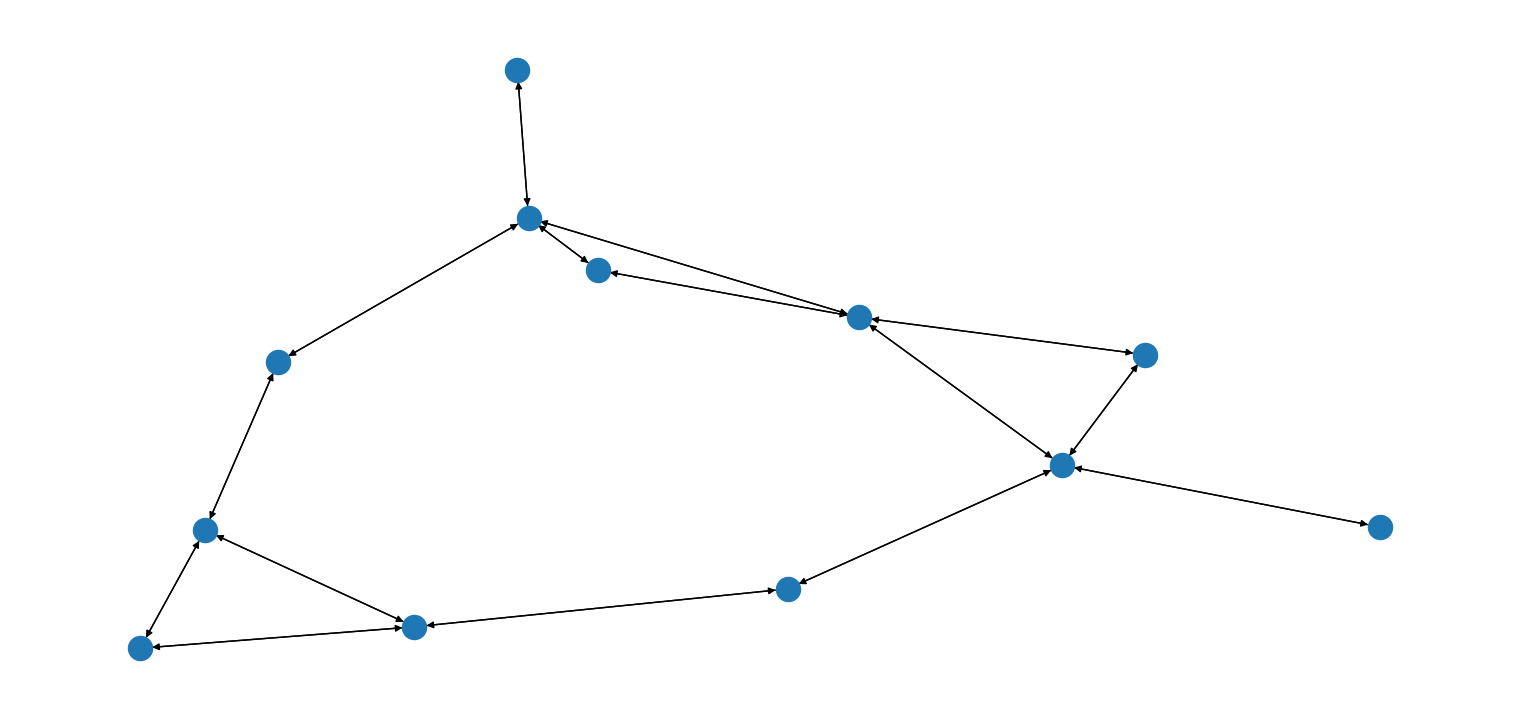

In [50]:
plot_net(g)

In [51]:
g.add_edges(non_mutual_matrix.row[selected_link_mask],non_mutual_matrix.col[selected_link_mask])

and after

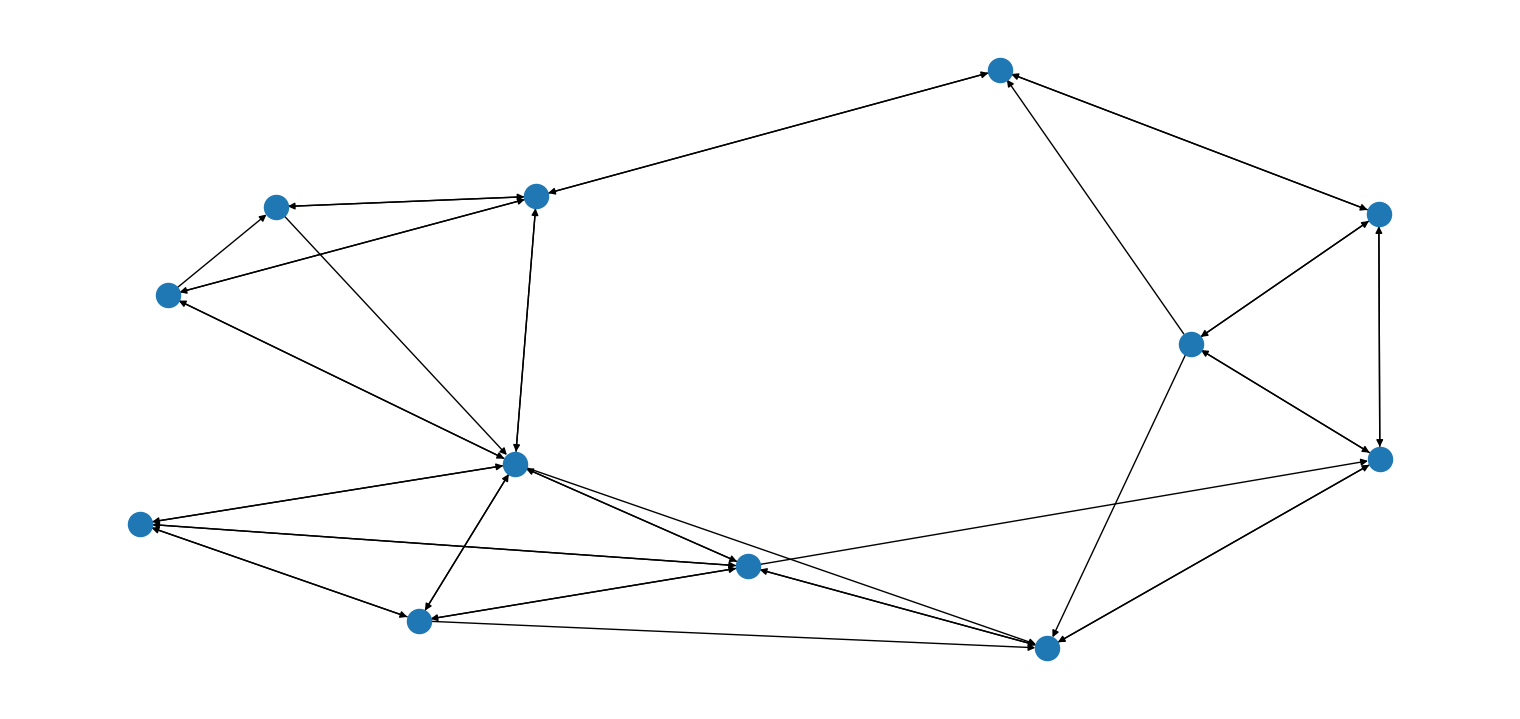

In [52]:
plot_net(g)